In [1]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("RealEstatePriceModel") \
    .getOrCreate()

# Charger les données dans un DataFrame Spark
df = spark.read.csv("dataset_with_density.csv", header=True, inferSchema=True)
df.show(truncate=False)

+-----------+-------------+------------------+---------------+---------------+--------------+---------------+--------------------------+-----------------+-----------+------------+-----------------------+----------------+-------------------+------------------+--------------+------------------+-------------+-----------+-------------------+-----------+-------------------+-----------+-------------------+-----------+-------------------+-----------+-------------------+-----------+---------------+-----------+-------------------+-------------------------+-------------------+--------------+----------------------------+-----------------------+---------------+---------+---------+--------------+-------------------------------+------------------+-------------------+------------------+------------------+---------------------+------------------+------------------+------------------+
|id_mutation|date_mutation|numero_disposition|nature_mutation|valeur_fonciere|adresse_numero|adresse_suffixe|adresse_no

In [2]:
from pyspark.sql.functions import col

df = df.select([col('valeur_fonciere'), col('surface_reelle_bati'), col('prix_m2'), col('type_local'), 
                # col('avg_neighbor_dist'), col('density'), col('avg_neighbor_price'), 
                col('latitude_r'), col('longitude_r')])
df.printSchema()

root
 |-- valeur_fonciere: double (nullable = true)
 |-- surface_reelle_bati: integer (nullable = true)
 |-- prix_m2: double (nullable = true)
 |-- type_local: string (nullable = true)
 |-- latitude_r: double (nullable = true)
 |-- longitude_r: double (nullable = true)



In [3]:
df.show(truncate=False)

+---------------+-------------------+------------------+-----------+------------------+-------------------+
|valeur_fonciere|surface_reelle_bati|prix_m2           |type_local |latitude_r        |longitude_r        |
+---------------+-------------------+------------------+-----------+------------------+-------------------+
|59000.0        |70                 |421.42857142857144|Maison     |0.84161462519224  |0.06525632484232623|
|30000.0        |61                 |491.8032786885246 |Maison     |0.8494885733928573|0.07329634112127079|
|45000.0        |40                 |1125.0            |Maison     |0.8422260140292136|0.06664136577683137|
|126000.0       |115                |1095.6521739130435|Maison     |0.8469066031106269|0.06498941163981874|
|109600.0       |68                 |1611.764705882353 |Maison     |0.8470886060450249|0.07404301042856648|
|140000.0       |70                 |2000.0            |Maison     |0.8428173490330817|0.07069604488189452|
|223000.0       |85         

In [4]:
# supprimer les lignes avec des valeurs nulles
print(f"Nombre de lignes avant suppression des valeurs nulles: {df.count()}")
df = df.dropna()
print(f"Nombre de lignes après suppression des valeurs nulles: {df.count()}")

Nombre de lignes avant suppression des valeurs nulles: 206946
Nombre de lignes après suppression des valeurs nulles: 206946


In [5]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder

# Indexation des colonnes catégorielles
categorical_columns = ['type_local']
indexers = [StringIndexer(inputCol=col, outputCol=col + "_indexed") for col in categorical_columns]

# Encodage des colonnes indexées
encoders = [OneHotEncoder(inputCol=col + "_indexed", outputCol=col + "_encoded") for col in categorical_columns]

In [6]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import Pipeline
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.feature import VectorAssembler, StandardScaler

# Diviser les données en ensembles d'entraînement et de test
train_data, test_data = df.randomSplit([0.8, 0.2], seed=42)

# Assembler les caractéristiques en un vecteur
feature_columns = [col for col in df.columns if col not in ['valeur_fonciere', 'prix_m2']+ categorical_columns]  + [col + "_encoded" for col in categorical_columns]
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

# Standardiser les données
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures")

# Créer et entraîner le modèle
rf = RandomForestRegressor(
    featuresCol="scaledFeatures", 
    labelCol="valeur_fonciere", 
    numTrees=30, 
    minInstancesPerNode=5
)

# Construire un pipeline
pipeline = Pipeline(stages=indexers + encoders + [assembler, scaler, rf])

# Entraîner le modèle
model = pipeline.fit(train_data)

In [7]:
# Faire des prédictions sur l'ensemble de test
predictions = model.transform(test_data)

# Évaluer le modèle
evaluator = RegressionEvaluator(
    labelCol="prix_m2", 
    predictionCol="prediction", 
    metricName="rmse"
)
rmse = evaluator.evaluate(predictions)
print(f"Root Mean Squared Error (RMSE) on test data = {rmse}")

Root Mean Squared Error (RMSE) on test data = 421099.6532083456


In [8]:
# Afficher quelques prédictions
predictions.select("prediction", "valeur_fonciere", "features").show(5)

+------------------+---------------+--------------------+
|        prediction|valeur_fonciere|            features|
+------------------+---------------+--------------------+
|172944.11921005577|            1.0|[75.0,0.816812309...|
|172944.11921005577|            1.0|[75.0,0.816812309...|
|172944.11921005577|            1.0|[75.0,0.816823095...|
|185058.14662043375|            1.0|[86.0,0.816826621...|
|205455.03196521374|            1.0|[110.0,0.83102742...|
+------------------+---------------+--------------------+
only showing top 5 rows



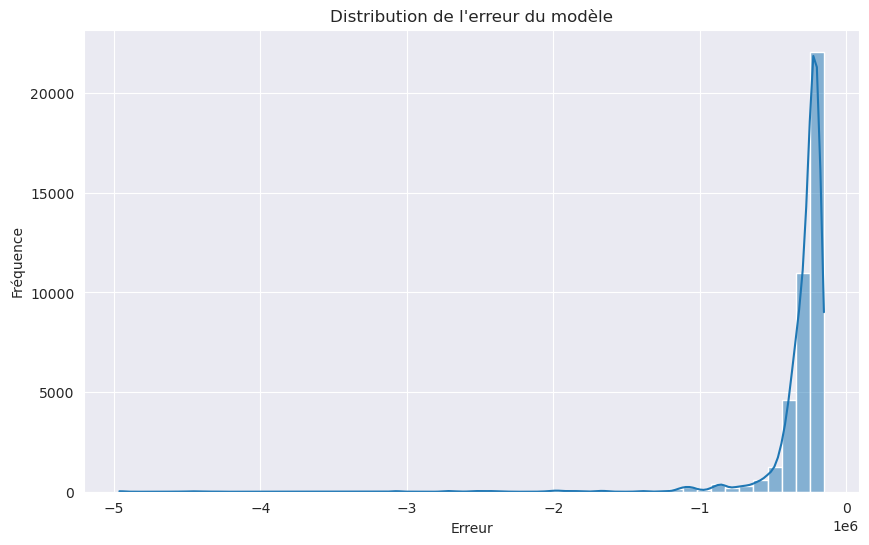

In [9]:
from matplotlib import pyplot as plt
import seaborn as sns

# Convertir les prédictions en Pandas DataFrame pour visualisation
predictions_pd = predictions.select("prediction", "prix_m2").toPandas()

# Calculer l'erreur
predictions_pd['erreur'] = predictions_pd['prix_m2'] - predictions_pd['prediction']

# Afficher la distribution de l'erreur
plt.figure(figsize=(10, 6))
sns.histplot(predictions_pd['erreur'], bins=50, kde=True)
plt.xlabel("Erreur")
plt.ylabel("Fréquence")
plt.title("Distribution de l'erreur du modèle")
plt.show()

In [10]:
model.write().overwrite().save("model")

In [11]:
spark.stop()